# Temp PR with pandas and numpy

In [273]:
from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

# nem kellenek
#import os.path
#import copy
#import operator
#from datetime import datetime, timedelta

## Utilities

In [47]:
# gives a dataframe from data
def get_data(filepath, nrows = None):
    edges_df = pd.read_csv(filepath, sep=' ', names=["time","source","target"], nrows = nrows)  
    return edges_df

In [49]:
# gives a static, weighted, directed graph from the dataframe
# weights: the number of interactions
def get_graph_from_df(df):
    G = nx.DiGraph()
    for index, edge in df.iterrows():
        if G.has_edge(edge[1], edge[2]):
            G[edge[1]][edge[2]]['weight'] += 1.0
        else:
            G.add_edge(edge[1], edge[2], weight = 1.0)
    return G

In [93]:
# calculates the indegree
# need to specify it later
def in_degree(df, nodes):
    temporal_in_degree = dict.fromkeys(nodes,0)
    for index, edge in df.iterrows():
        temporal_in_degree[edge[2]] += 1
    return temporal_in_degree

## Computations for one dataset

### Read the data

In [94]:
filepath = '/mnt/idms/temporalNodeRanking/data/filtered_timeline_data/tsv/15o/15o_only_first_mentions.csv'
df = get_data(filepath)
G = get_graph_from_df(df)
nodes = G.nodes()

### Compute centrality metrics

   #### Columns of the array 'centrality_values'
   ```
   Index    Name
   -----------------------------------
     0      node label
     1      simple indegree
     2      indegree with damping factor
     3      temporal pagerank
     4      active mass (for temp pr)
     5      static pagerank
   ```

In [276]:
# columns: node, simple indegree, indegree with damping factor, temporal pagerank, active mass (for temp pr), static pagerank
centrality_values = np.outer(nodes, [1,0,0.0,0.0,0.0,0.0])
nodes_array = np.asarray(nodes)

# indegree damping factor
damping_factor = 0.999

# temporal pagerank jumping and transition probability
alpha = 0.9
beta = 0.5
if beta == 1:
    beta = 0

# lists for correlation stats
tau_pr = []
spearman_pr = []
tau_indegree = []
spearman_indegree = []
tau_indegree_damped = []
spearman_indegree_damped = []
x = []

# normal pagerank (for static graph)
pagerank = nx.pagerank(G, alpha = alpha)
centrality_values[:,5] = [value for (node, value) in sorted(pagerank.items())]

for i, edge in df.iterrows():
    # get the row index of the source and target node
    edge_target_index = nodes_array.searchsorted(edge[2])
    edge_source_index = nodes_array.searchsorted(edge[1])
    
    # simple indegree
    centrality_values[edge_target_index, 1] +=1

    # indegree with damping factor
    centrality_values[:,2] *= damping_factor
    centrality_values[edge_target_index,2] +=1
    
    # temporal pagerank
    centrality_values[edge_source_index,3] += 1-alpha
    centrality_values[edge_source_index,4] += 1-alpha
    centrality_values[edge_target_index,3] += centrality_values[edge_source_index,4]*alpha
    centrality_values[edge_target_index,4] += centrality_values[edge_source_index,4]*(1-beta)*alpha
    centrality_values[edge_source_index,4] *= beta
    
    # computing correlations
    if i % 1000 == 0:
        x.append(i)
        
        # between temporal pagerank and static pagerank
        tau_pr.append(stats.kendalltau(centrality_values[:,3], centrality_values[:,5])[0])
        spearman_pr.append(stats.spearmanr(centrality_values[:,3], centrality_values[:,5])[0])
        
        # between temporal pagerank and simple indegree
        tau_indegree.append(stats.kendalltau(centrality_values[:,3], centrality_values[:,1])[0])
        spearman_indegree.append(stats.spearmanr(centrality_values[:,3], centrality_values[:,1])[0])
        
        # between temporal pagerank and damped indegree
        tau_indegree_damped.append(stats.kendalltau(centrality_values[:,3], centrality_values[:,2])[0])
        spearman_indegree_damped.append(stats.spearmanr(centrality_values[:,3], centrality_values[:,2])[0])

### Plot the correlations

In [299]:
xx = [item / 1000 for item in x]

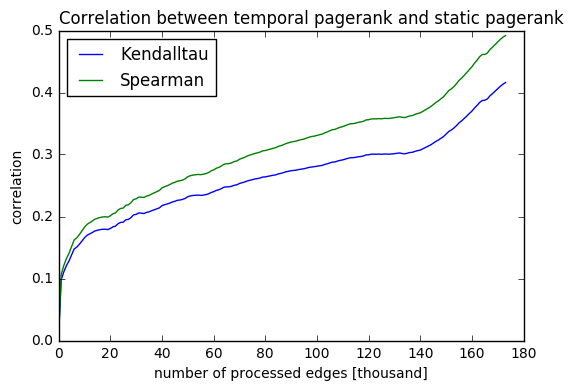

In [296]:
plt.plot(xx,tau_pr,label='Kendalltau')
plt.plot(xx,spearman_pr, label='Spearman')
plt.ylabel('correlation')
plt.xlabel('number of processed edges [thousand]')
plt.legend(loc='best')
plt.title('Correlation between temporal pagerank and static pagerank', loc='left')

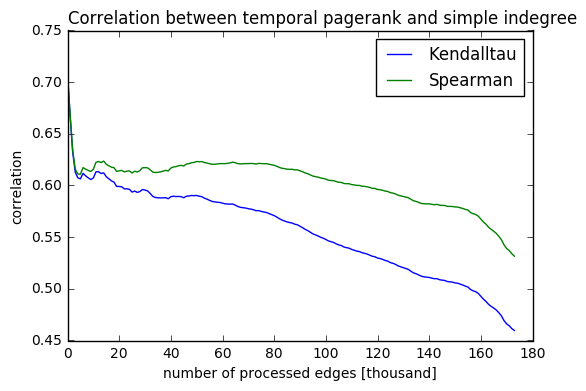

In [297]:
plt.plot(xx,tau_indegree,label='Kendalltau')
plt.plot(xx,spearman_indegree, label='Spearman')
plt.ylabel('correlation')
plt.xlabel('number of processed edges [thousand]')
plt.legend(loc='best')
plt.title('Correlation between temporal pagerank and simple indegree', loc='left')

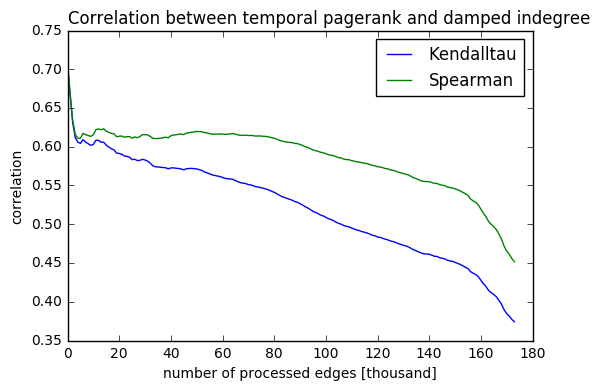

In [298]:
plt.plot(xx,tau_indegree_damped,label='Kendalltau')
plt.plot(xx,spearman_indegree_damped, label='Spearman')
plt.ylabel('correlation')
plt.xlabel('number of processed edges [thousand]')
plt.legend(loc='best')
plt.title('Correlation between temporal pagerank and damped indegree', loc='left')

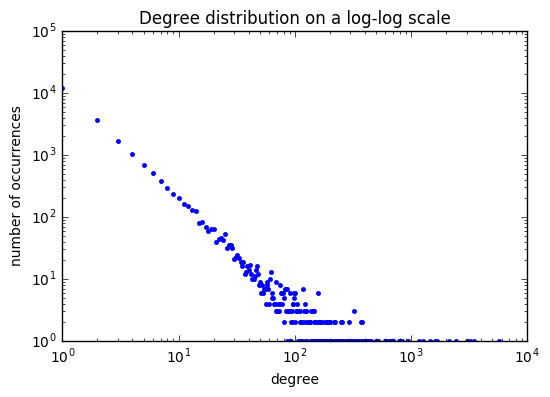

In [300]:
# show degree distribution on a log-log scale
x = []
y = []
c = Counter(degrees)
for key, value in c.items():
    x.append(key)
    y.append(value)
plt.loglog(x,y,'.')
plt.ylabel('number of occurrences')
plt.xlabel('degree')
plt.title('Degree distribution on a log-log scale')

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------Innentől nem érdekes

### PR számolás

In [36]:
def flowPR(p_prime_nodes, ref_pr, stream, RS, current, iters = 1000000, alpha = 0.85, beta=0.001, gamma=0.9999, normalization = 1.0, padding = 0):
    """ current: s
        RS: r
        p_prime_node: h*/h'
        """
    if beta == 1.0:
        beta = 0.0
        
    tau = []
    pearson = []
    spearman = []
    error = []
    x = []
    i = 0

    rank_order = [key for (key, value) in sorted(ref_pr.items(), key=operator.itemgetter(1), reverse=True)]
    ordered_pr = np.array([ref_pr[k] for k in rank_order])

    for e in stream:
        i += 1

        RS[e[0]] = RS.get(e[0], 0.0) * gamma + 1.0 * (1.0 - alpha) * p_prime_nodes[e[0]] * normalization
        RS[e[1]] = RS.get(e[1], 0.0) * gamma + (current.get(e[0], 0.0) + 1.0 * (1.0 - alpha) * p_prime_nodes[e[0]]) * alpha * normalization
        current[e[1]] = current.get(e[1], 0.0) + (current.get(e[0], 0.0) + 1.0 * (1.0 - alpha)* p_prime_nodes[e[0]]) * alpha *(1 - beta)
        current[e[0]] = current.get(e[0], 0.0) * beta


        if (i % 100 == 0 or i == len(stream)) and len(RS) == len(ordered_pr):
            if i == iters-1:
                print (sum(RS.values()))
            sorted_RS4 = np.array([RS[k] / sum(RS.values()) for k in rank_order])
            tau.append(scipy.stats.kendalltau(sorted_RS4, ordered_pr)[0])
            pearson.append(scipy.stats.pearsonr(sorted_RS4, ordered_pr)[0])
            spearman.append(scipy.stats.spearmanr(sorted_RS4, ordered_pr)[0])
            error.append(np.linalg.norm(sorted_RS4 - ordered_pr))
            x.append(i+padding)

        if i == iters-1:
            print (sum(RS.values()))

    sorted_RS4 = np.array([RS[k] / sum(RS.values()) for k in rank_order])

    return RS, current, tau, spearman, pearson, error, x

In [40]:
filepath = './../temporal-pagerank/Data/students.txt'
df = get_data(filepath, 15)
G = get_graph_from_df(df)

norm = sum(G.out_degree(weight='weight').values())
sampling_edges = {e[:-1]: e[-1]['weight']/norm for e in G.edges_iter(data=True)}
stream = list(sampling_edges.keys())

# basic (degree personalization)
personalization = {k: v / norm for k, v in G.out_degree(weight='weight').items()}
p_prime_nodes = {i: 1/nx.number_of_nodes(G) for i in G.nodes_iter()}
pr_basic = nx.pagerank(G)
RS4_basic, current_basic = {}, {}
RS4_basic, current_basic, tau_basic, spearman_basic, pearson_basic, error_basic, x = flowPR(p_prime_nodes, pr_basic, stream, RS4_basic, current_basic)


In [45]:
pr_basic

{1: 0.02682791813318128,
 3: 0.21462334506545025,
 32: 0.022803278704391097,
 70: 0.09575135529955466,
 105: 0.022803278704391097,
 193: 0.02682791813318128,
 282: 0.09575135529955466,
 312: 0.022803278704391097,
 393: 0.022803278704391097,
 504: 0.022803278704391097,
 509: 0.022803278704391097,
 790: 0.022803278704391097,
 800: 0.022803278704391097,
 809: 0.06892343716637338,
 1154: 0.022803278704391097,
 1373: 0.022803278704391097,
 1713: 0.24326188385879338}

In [43]:
p_prime_nodes

{1: 0.058823529411764705,
 3: 0.058823529411764705,
 32: 0.058823529411764705,
 70: 0.058823529411764705,
 105: 0.058823529411764705,
 193: 0.058823529411764705,
 282: 0.058823529411764705,
 312: 0.058823529411764705,
 393: 0.058823529411764705,
 504: 0.058823529411764705,
 509: 0.058823529411764705,
 790: 0.058823529411764705,
 800: 0.058823529411764705,
 809: 0.058823529411764705,
 1154: 0.058823529411764705,
 1373: 0.058823529411764705,
 1713: 0.058823529411764705}

In [41]:
RS4_basic, current_basic, tau_basic, spearman_basic, pearson_basic, error_basic, x

({1: 0.008823529411764707,
  3: 0.07056353435232358,
  32: 0.0075000000000000015,
  70: 0.016322779411764708,
  105: 0.0075000000000000015,
  193: 0.008823529411764707,
  282: 0.022691272058823535,
  312: 0.0075000000000000015,
  393: 0.0075000000000000015,
  504: 0.0075000000000000015,
  509: 0.0075000000000000015,
  790: 0.0075000000000000015,
  800: 0.0075000000000000015,
  809: 0.0075000000000000015,
  1154: 0.0075000000000000015,
  1373: 0.0075000000000000015,
  1713: 0.04783065528083824},
 {1: 0.0,
  3: 0.0,
  32: 0.007492500000000002,
  70: 7.4925000000000015e-06,
  105: 0.007492500000000002,
  193: 0.0,
  282: 0.013854756375000003,
  312: 0.007492500000000002,
  393: 0.007492500000000002,
  504: 0.007492500000000002,
  509: 0.007492500000000002,
  790: 0.007492500000000002,
  800: 0.007492500000000002,
  809: 0.007492500000000002,
  1154: 0.007492500000000002,
  1373: 0.007492500000000002,
  1713: 0.013862248875000002},
 [0.86513297023045843],
 [0.91082637885398221],
 [0.933322

## Teszt

(array([ 141.,   36.,   23.,    8.,    5.,    4.,    2.,    2.,    1.,    0.]),
 array([  100.,   200.,   300.,   400.,   500.,   600.,   700.,   800.,
          900.,  1000.,  1100.]),
 <a list of 10 Patch objects>)

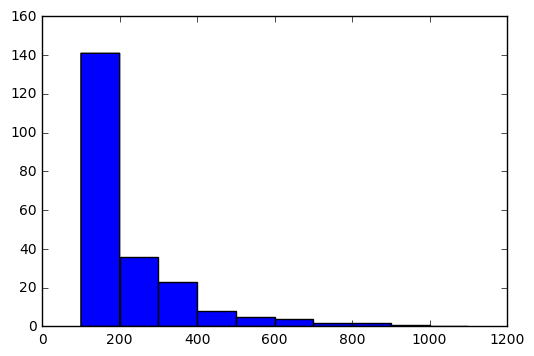

In [148]:
degrees = centrality_values[:,1]
# np.histogram(degrees, range = (1,11))

plt.hist(degrees, range = (100,1100))

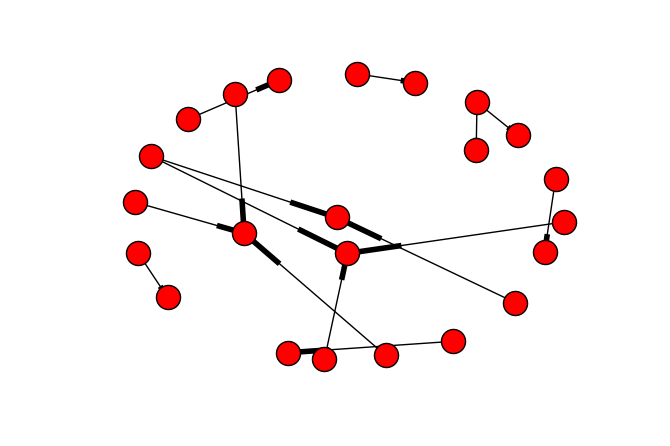

In [51]:
%matplotlib inline
nx.draw(G)

In [89]:
gr = nx.DiGraph()
gr.add_edge(4,3)
gr.nodes()

[3, 4]

In [95]:
a = [1,2,3,54]
b = [1,0]
np.outer(a, b)

array([[ 1,  0],
       [ 2,  0],
       [ 3,  0],
       [54,  0]])

In [107]:
# np.searchsorted([1,2,3,4], 4)
arr = np.array([1,2,3,4])
arr.searchsorted(5)

4

In [67]:
d = {21: 1, 34: 2}
print(d)
keys = d.keys()
values = d.values()
print('keys: ')
list(keys)

{34: 2, 21: 1}
keys: 


[34, 21]

In [74]:
s = {1,2}
s.add(2)
s.add(3)
s.add(1)
s.add('sd')
s

{'sd', 1, 2, 3}

## Nem kell már

In [ ]:
# nem használjuk már
def first_n_edge(filepath, n = 0):
    G = nx.DiGraph()
    edges_df = pd.read_csv(filepath, sep=' ', names=["time","source","target"])
    for i in iter(range(n)):
        if edges_df.ix[i]["source"] != edges_df.ix[i]["target"]:
            G.add_edge(edges_df.ix[i]["source"],edges_df.ix[i]["target"],{'time':edges_df.ix[i]["time"]})
        
    return G